<a href="https://colab.research.google.com/github/cserajdeep/ViT-MNIST-DIGIT-CLASSIFICATION/blob/main/ViT_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## https://towardsdatascience.com/a-demonstration-of-using-vision-transformers-in-pytorch-mnist-handwritten-digit-recognition-407eafbc15b0

In [ ]:
import torch
import torchvision

torch.manual_seed(42)

DOWNLOAD_PATH = '/data/mnist'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=True, download=True,
                                       transform=transform_mnist)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_mnist)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

In [ ]:
def evaluate(model, data_loader, loss_history):
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [ ]:
!pip install einops

In [ ]:
import torch
import torch.nn.functional as F

from torch import nn
from einops import rearrange
import time

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

In [ ]:
N_EPOCHS = 25

start_time = time.time()
model = ViT(
    image_size=28, 
    patch_size=7, 
    num_classes=10, 
    channels=1, 
    dim=64, 
    depth=6, 
    heads=8, 
    mlp_dim=128,
    dropout = 0.1,
    emb_dropout = 0.1)
optimizer = optim.Adam(model.parameters(), lr=0.003)

train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/60000 (  0%)]  Loss: 2.3330
[10000/60000 ( 17%)]  Loss: 0.3244
[20000/60000 ( 33%)]  Loss: 0.3293
[30000/60000 ( 50%)]  Loss: 0.1572
[40000/60000 ( 67%)]  Loss: 0.1296
[50000/60000 ( 83%)]  Loss: 0.1162

Average test loss: 0.1538  Accuracy: 9516/10000 (95.16%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.1916
[10000/60000 ( 17%)]  Loss: 0.1409
[20000/60000 ( 33%)]  Loss: 0.0399
[30000/60000 ( 50%)]  Loss: 0.1252
[40000/60000 ( 67%)]  Loss: 0.1743
[50000/60000 ( 83%)]  Loss: 0.0826

Average test loss: 0.1502  Accuracy: 9551/10000 (95.51%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.1901
[10000/60000 ( 17%)]  Loss: 0.0654
[20000/60000 ( 33%)]  Loss: 0.1272
[30000/60000 ( 50%)]  Loss: 0.0564
[40000/60000 ( 67%)]  Loss: 0.0696
[50000/60000 ( 83%)]  Loss: 0.0540

Average test loss: 0.1119  Accuracy: 9682/10000 (96.82%)

Epoch: 4
[    0/60000 (  0%)]  Loss: 0.0449
[10000/60000 ( 17%)]  Loss: 0.0482
[20000/60000 ( 33%)]  Loss: 0.0806
[30000/60000 ( 50%)]  Loss: 0.0687
[40000/60000 ( 67

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

In [ ]:
 torch.save(model.state_dict(), 'model-vit-mnist.pth')

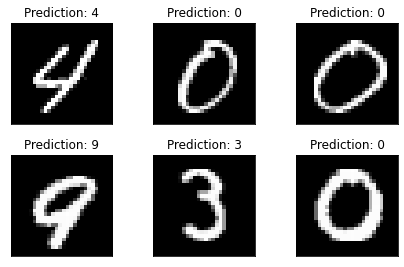

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
  output = model(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

Label: 7 , Predicted: 7


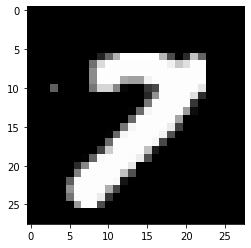

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb =  model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

k = 27
img = example_data[k]
plt.imshow(img[0], cmap='gray')
print('Label:', example_targets[k].item(), ', Predicted:', predict_image(img, model))  

In [ ]:
example_targets

tensor([4, 0, 0, 9, 3, 0, 5, 4, 3, 5, 8, 3, 5, 4, 2, 1, 5, 4, 3, 0, 8, 5, 3, 1,
        9, 8, 6, 7, 9, 3, 5, 9, 7, 9, 5, 2, 0, 0, 4, 7, 4, 1, 1, 8, 2, 4, 8, 7,
        1, 3, 2, 0, 6, 3, 9, 6, 5, 5, 6, 2, 7, 8, 4, 9, 1, 3, 3, 9, 3, 4, 5, 4,
        3, 9, 1, 6, 2, 8, 9, 1, 0, 3, 2, 3, 9, 7, 7, 8, 9, 3, 0, 8, 2, 1, 0, 5,
        5, 4, 8, 7, 8, 2, 6, 4, 4, 4, 2, 7, 2, 2, 9, 7, 5, 3, 1, 8, 4, 3, 1, 3,
        8, 8, 0, 2, 6, 1, 5, 5, 9, 0, 0, 3, 8, 3, 7, 1, 5, 7, 1, 0, 6, 6, 2, 6,
        9, 7, 7, 3, 1, 1, 1, 6, 4, 7, 7, 2, 6, 7, 8, 1, 0, 1, 5, 3, 1, 7, 6, 3,
        2, 4, 1, 6, 5, 4, 8, 6, 5, 3, 9, 4, 0, 9, 2, 9, 5, 2, 0, 0, 5, 5, 9, 5,
        7, 5, 0, 1, 7, 6, 1, 7, 1, 2, 2, 6, 5, 5, 4, 5, 4, 9, 9, 2, 5, 3, 1, 0,
        8, 2, 2, 1, 8, 2, 8, 0, 8, 9, 5, 3, 0, 2, 2, 4, 8, 4, 1, 6, 8, 9, 7, 4,
        7, 6, 1, 4, 1, 1, 3, 6, 3, 5, 0, 1, 8, 3, 7, 0, 1, 7, 5, 9, 1, 0, 2, 4,
        4, 8, 2, 9, 3, 0, 1, 4, 8, 8, 4, 9, 3, 8, 7, 4, 7, 2, 0, 3, 7, 7, 1, 0,
        1, 4, 0, 2, 7, 9, 9, 7, 1, 8, 9,